Question 1

Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) [3 Marks]

In [ ]:
import torch
import cv2
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore') #ignore the warnings and focus on important features

# Set env CUDA_LAUNCH_BLOCKING=1,  it ensures that the operations complete before proceeding to the next steps.
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange #useful for rearranging, reshaping, and transposing
    print("Already installed, successfully imported rearrange")
except ImportError:
    %pip install einops
    from einops import rearrange


Already installed, successfully imported rearrange


In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

img = torchvision.io.read_image("dog.jpg")
print(img.shape)

--2024-09-19 09:40:48--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.65.229.91, 18.65.229.102, 18.65.229.20, ...
Connecting to segment-anything.com (segment-anything.com)|18.65.229.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-09-19 09:40:48 (10.6 MB/s) - ‘dog.jpg’ saved [221810/221810]

torch.Size([3, 1365, 2048])


torch.Size([3, 400, 400])

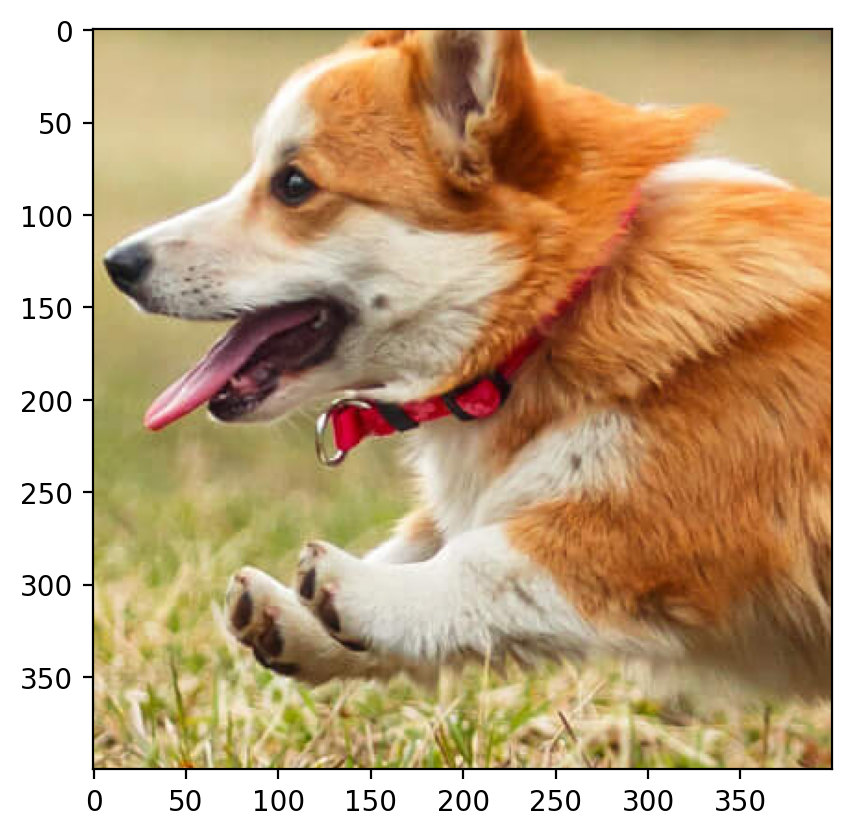

In [ ]:

from sklearn import preprocessing


scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

# cales features to a specified range
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
crop.shape

In [ ]:
crop = crop.numpy()
img = np.transpose(crop, (1, 2, 0))  # Shape now is (400, 400, 3)

resized_img = cv2.resize(img, (200, 200))  # OpenCV expects (width, height)

# back to (channels, height, width) format
resized_img = np.transpose(resized_img, (2, 0, 1))
resized_img = torch.from_numpy(resized_img)
low_res_image = resized_img.float().to(device)

torch.Size([3, 200, 200])

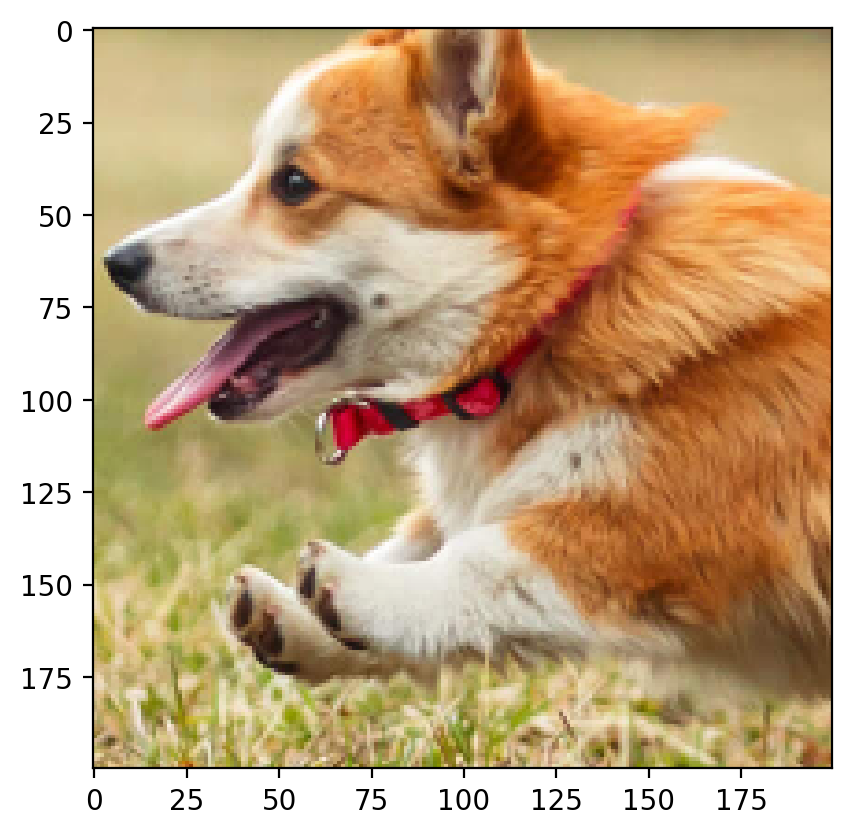

In [ ]:
plt.imshow(rearrange(resized_img, 'c h w -> h w c').cpu().numpy())
resized_img.shape

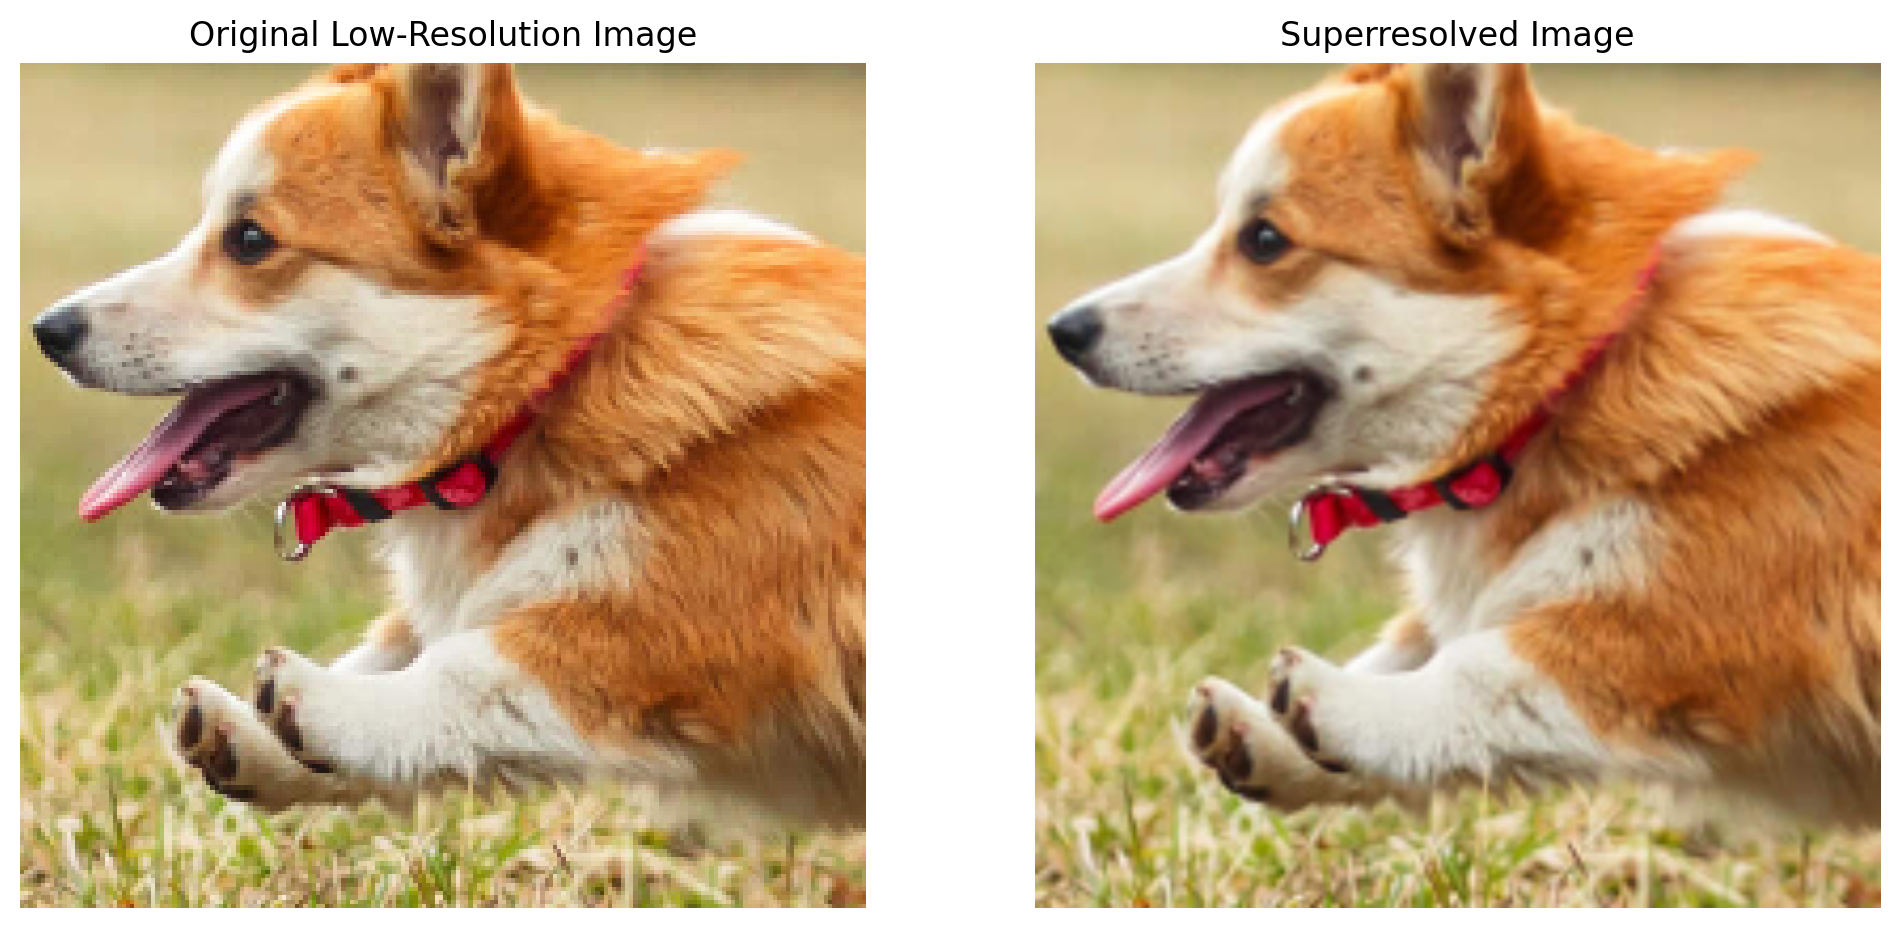

In [ ]:
def upscale_image(image, scale_factor):
    # Convert tensor to numpy array
    image_np = image.cpu().numpy()
    image_np = np.transpose(image_np, (1, 2, 0))  # Change to (height, width, channels)

    # Perform resizing using OpenCV (bilinear interpolation)
    height, width, _ = image_np.shape
    new_size = (int(width * scale_factor), int(height * scale_factor))
    upscaled_image = cv2.resize(image_np, new_size, interpolation=cv2.INTER_LINEAR)

    # Convert back to tensor and normalize
    upscaled_image = np.transpose(upscaled_image, (2, 0, 1))  # Change to (channels, height, width)
    upscaled_image = torch.from_numpy(upscaled_image).float().to(device)

    return upscaled_image

# Perform superresolution
scale_factor = 5
superresolved_image = upscale_image(low_res_image, scale_factor)

# Convert low resolution image to numpy array for comparison
low_res_image_np = low_res_image.cpu().numpy()
low_res_image_np = np.transpose(low_res_image_np, (1, 2, 0))  # Change to (height, width, channels)

# Convert superresolved image to numpy array for comparison
superresolved_image_np = superresolved_image.cpu().numpy()
superresolved_image_np = np.transpose(superresolved_image_np, (1, 2, 0))  # Change to (height, width, channels)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(low_res_image_np)
axes[0].set_title('Original Low-Resolution Image')
axes[0].axis('off')

axes[1].imshow(superresolved_image_np)
axes[1].set_title('Superresolved Image')
axes[1].axis('off')

plt.show()


The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: [1 Marks]

RMSE on predicted v/s ground truth high resolution image
Peak SNR on predicted v/s ground truth high resolution image

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.metrics as metrics
from torchvision.transforms import ToTensor, Resize

def compute_rmse(pred_image, gt_image):
    pred_image_np = pred_image.cpu().numpy()
    gt_image_np = gt_image.cpu().numpy()

    # Compute RMSE
    mse = np.mean((pred_image_np - gt_image_np) ** 2)
    rmse = np.sqrt(mse)

    return rmse

def compute_psnr(pred_image, gt_image):
    pred_image_np = pred_image.cpu().numpy()
    gt_image_np = gt_image.cpu().numpy()

    # Compute PSNR
    psnr = metrics.peak_signal_noise_ratio(gt_image_np, pred_image_np, data_range=1.0)

    return psnr

ground_trut_img = torch.from_numpy(crop)
# Compute RMSE
rmse = compute_rmse(superresolved_image, ground_trut_img)
print(f"RMSE: {rmse.item()}")

# Compute PSNR
psnr = compute_psnr(superresolved_image, ground_trut_img)
print(f"PSNR: {psnr} dB")


RMSE: 0.02216472020649209
PSNR: 33.086754931816735 dB
